In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import kerastuner as kt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\country.csv")

In [5]:
country_names = df['country']

df = df.drop('country', axis=1)

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(df)

In [7]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [9]:
def build_autoencoder(hp):
    input_dim = X_train.shape[1]

    latent_dim = hp.Int("latent_dim", min_value=2, max_value=8, step=2)

    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(hp.Int("encoder_units", min_value=32, max_value=128, step=32), activation="relu")(inputs)
    x = layers.Dropout(hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1))(x)
    latent = layers.Dense(latent_dim, activation="relu", name="latent_space")(x)

    x = layers.Dense(hp.Int("decoder_units", min_value=32, max_value=128, step=32), activation="relu")(latent)
    x = layers.Dropout(hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1))(x)
    outputs = layers.Dense(input_dim, activation="linear")(x)

    autoencoder = keras.Model(inputs, outputs)

    autoencoder.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
        loss="mse"
    )

    return autoencoder

In [10]:
tuner = kt.RandomSearch(
    build_autoencoder,
    objective="val_loss",
    max_trials=2,
    executions_per_trial=1,
    directory="autoencoder_tuning",
    project_name="iris_autoencoder"
)

In [11]:
tuner.search(X_train, X_train, epochs=2, validation_data=(X_test, X_test), verbose=1)

Trial 2 Complete [00h 00m 05s]
val_loss: 0.6194047331809998

Best val_loss So Far: 0.5083528757095337
Total elapsed time: 00h 00m 12s


In [12]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [13]:
print(f"""
Best Hyperparameters:
- latent_dim: {best_hps.get('latent_dim')}
- encoder_units: {best_hps.get('encoder_units')}
- decoder_units: {best_hps.get('decoder_units')}
- dropout: {best_hps.get('dropout')}
- learning_rate: {best_hps.get('learning_rate')}
""")


Best Hyperparameters:
- latent_dim: 6
- encoder_units: 128
- decoder_units: 96
- dropout: 0.1
- learning_rate: 0.01



In [14]:
best_autoencoder = tuner.hypermodel.build(best_hps)
history = best_autoencoder.fit(X_train, X_train, epochs=50, validation_data=(X_test, X_test), verbose=1)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 0.8458 - val_loss: 0.6251
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.4706 - val_loss: 0.3222
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3981 - val_loss: 0.2840
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3524 - val_loss: 0.2774
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2690 - val_loss: 0.1810
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2047 - val_loss: 0.1413
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1709 - val_loss: 0.1109
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1489 - val_loss: 0.1052
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1435 - val_loss: 0.1161
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1857 - val_loss: 0.1515
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1669 - val_loss: 0.1169
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.1155 - val_loss: 0.0878


In [15]:
test_loss = best_autoencoder.evaluate(X_test, X_test)
print(f"Test Reconstruction Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0933 
Test Reconstruction Loss: 0.0924


In [16]:
X_test_reconstructed = best_autoencoder.predict(X_test)

reconstruction_errors = np.mean(np.abs(X_test - X_test_reconstructed), axis=1)

threshold = np.percentile(reconstruction_errors, 95)

anomalies = reconstruction_errors > threshold

print(f"Jumlah Anomali Terdeteksi: {np.sum(anomalies)} dari {len(X_test)} sampel")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Jumlah Anomali Terdeteksi: 2 dari 34 sampel


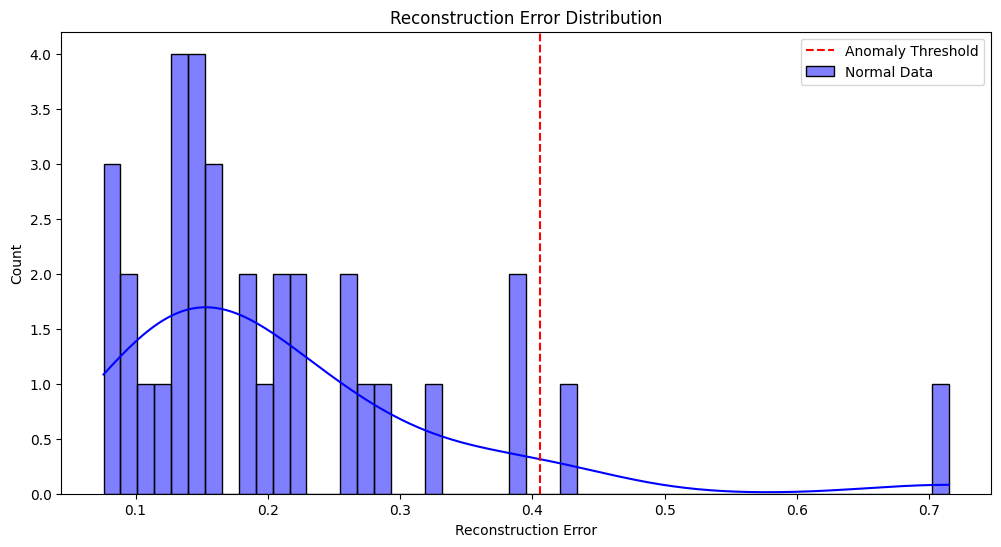

In [19]:
plt.figure(figsize=(12, 6))
sns.histplot(reconstruction_errors, bins=50, kde=True, color='blue', label='Normal Data')
plt.axvline(threshold, color='red', linestyle='dashed', label='Anomaly Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.show()

In [20]:
encoder = keras.Model(best_autoencoder.input, best_autoencoder.get_layer("latent_space").output)

In [21]:
X_latent = encoder.predict(X)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [22]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_latent)

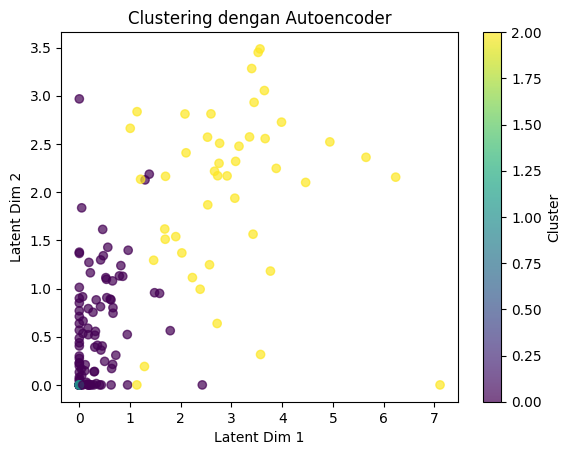

In [23]:
plt.scatter(X_latent[:, 0], X_latent[:, 1], c=clusters, cmap="viridis", alpha=0.7)
plt.colorbar(label="Cluster")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.title("Clustering dengan Autoencoder")
plt.show()